# Humpback Whale Identification Challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
torch.cuda.is_available()

False

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "data/"
TRAINING_CSV_FILE="traing_data_without_new_whale_v2.csv"
TRAINING_FOLDER="trainv2"

## Exploring the dataset

In [6]:
! ls {PATH}

Data Preprocessing.ipynb  test.zip   traing_data_without_new_whale.csv
models			  tmp	     traing_data_without_new_whale_v2.csv
sample_submission.csv	  train      trainv2
test			  train.csv  train.zip


In [7]:
training_data = pd.read_csv(f'{PATH}train.csv')
training_data.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [8]:
training_data.shape

(9850, 2)

In [9]:
#traing_data_without_new_whale = training_data[training_data['Id'] != "new_whale"]
#traing_data_without_new_whale.to_csv(f'{PATH}traing_data_without_new_whale.csv', index=False)
traing_data_without_new_whale = pd.read_csv(f'{PATH}{TRAINING_CSV_FILE}')
traing_data_without_new_whale.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [10]:
print('Number of traing images %s' % len(os.listdir(f'{PATH}{TRAINING_FOLDER}'))) 
print('Number of test images %s' % len(os.listdir(f'{PATH}test'))) 

Number of traing images 33650
Number of test images 15610


So, the number of test images is way more than number of traing images.

In [14]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{PATH}{train}/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')        

In [15]:
np.random.seed(42)

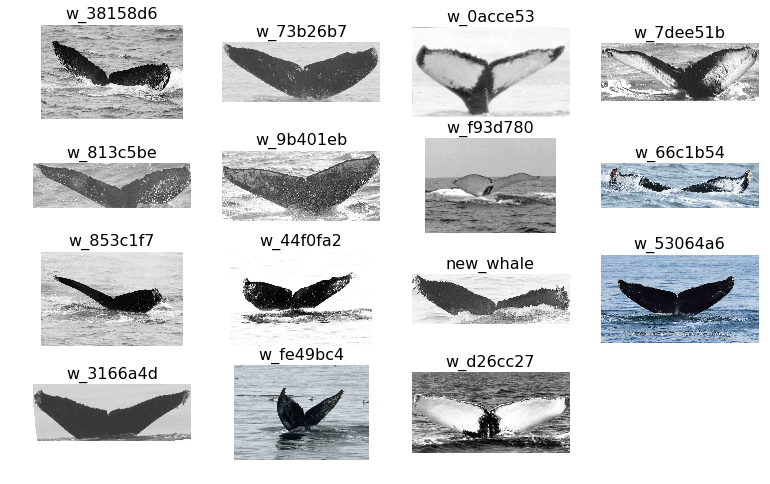

In [16]:
rand_rows = training_data.sample(frac=1.)[:15]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

Let's take a look at the breakdown of number of image per category.

In [17]:
print("Number of categories: %s" % len(training_data['Id'].unique()))

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

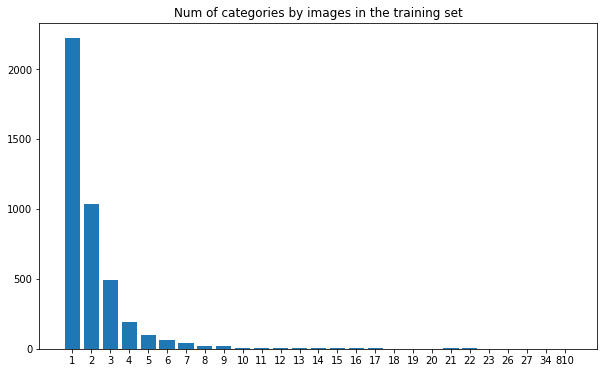

In [18]:
size_buckets = Counter(training_data['Id'].value_counts().values)

plt.figure(figsize=(10, 6))
plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")
plt.show()

So it seems a vast majority of classes only have a single image in them

In [19]:
training_data['Id'].value_counts().head(10)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_fd1cb9d     22
w_693c9ee     22
w_ab4cae2     22
w_987a36f     21
w_73d5489     21
Name: Id, dtype: int64

In [20]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [38]:
is_grey = [is_grey_scale(f'{PATH}train/{i}') for i in training_data['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(f"% of grey images: {grey_perc}")

KeyboardInterrupt: 

As only half of the images are grey scale I think it would be good idea to transform gray scale images into RGB images.

It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

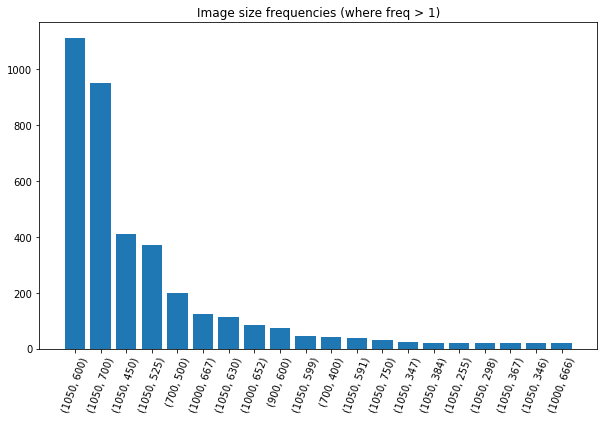

In [22]:
img_sizes = Counter([Image.open(f'{PATH}train/{i}').size for i in training_data['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Building initial model

In [11]:
sz=64
arch=resnet34
bs=64

label_csv = f'{PATH}{TRAINING_CSV_FILE}'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
val_idxs.size

6568

In [12]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    data= ImageClassifierData.from_csv(PATH, TRAINING_FOLDER, f'{PATH}{TRAINING_CSV_FILE}', tfms=tfms,
                    val_idxs=val_idxs, test_name='test', bs=bs)
    return data #if sz>300 else data.resize(340, 'tmp') 

In [13]:
data = get_data(sz, bs)
fn = PATH+data.trn_ds.fnames[0]; fn

'data/trainv2/00022e1a.jpg'

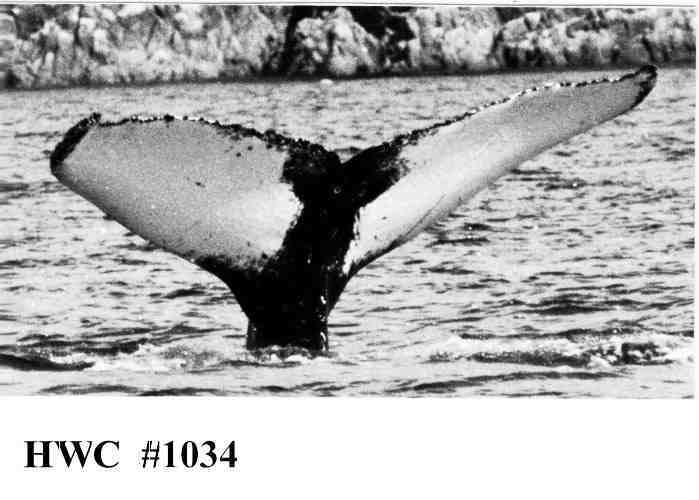

In [14]:
img = PIL.Image.open(fn); img

In [15]:
print(img.size)
data.c

(699, 500)


4250

In [48]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [49]:
learn.model

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=4250, bias=True)
  (7): LogSoftmax()
)

 94%|█████████▎| 385/411 [00:19<00:01, 19.45it/s, loss=40.3]

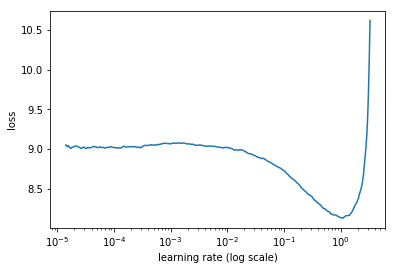

 94%|█████████▎| 385/411 [00:30<00:02, 12.83it/s, loss=40.3]

In [38]:
lrf=learn.lr_find()
learn.sched.plot()

In [39]:
lr = 0.05

In [ ]:
learn.fit(lr, 5, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.34564    0.891808   0.911845  
    1      0.338255   0.871173   0.913672                    
    2      0.413294   1.001876   0.908496                    
    3      0.265654   0.973196   0.910171                    
 52%|█████▏    | 215/411 [00:10<00:10, 19.58it/s, loss=0.294]

In [22]:
learn.save('64_trainv2_01')

In [47]:
learn.load('64_trainv2_01')

In [24]:
log_pred,y = learn.TTA()

In [25]:
probs = np.mean(np.exp(log_pred),0)
print("Log prediction shape***************** ", log_pred.shape)
print("Probability shape**************** ", probs.shape)
print("Number of output classes********* ", len(data.classes))

Log prediction shape*****************  (5, 6568, 4250)
Probability shape****************  (6568, 4250)
Number of output classes*********  4250


In [27]:
data.test_ds.fnames[0][5:]

'a779821d.jpg'

In [42]:
log_pred = learn.predict(is_test=True)
probs = np.exp(log_pred)
probs.shape

(15610, 4250)

## Preparing for the Kaggle submission

In [43]:
tmp_list=[]
for im,row in zip(data.test_ds.fnames,probs):
    pred_row = np.argsort(-row)[:4]
    str="new_whale"
    for i in pred_row:
        str = str+" "+data.classes[i]
    tmp_list.append((im[5:], str))    
submission_df=pd.DataFrame(tmp_list, columns=['Image','Id'])
submission_df.head()

,Image,Id
0,a779821d.jpg,new_whale w_3eaef21 w_002b682 w_8697f5f w_e9ffbe9
1,c064ec31.jpg,new_whale w_2739d94 w_715d152 w_5a6bf1f w_c34afd7
2,6a5e374d.jpg,new_whale w_1eafe46 w_7104905 w_14c8f15 w_896023f
3,5df80c24.jpg,new_whale w_5a81425 w_5010531 w_c128384 w_a3a65b3
4,68596681.jpg,new_whale w_1fb42f1 w_44cccf6 w_22b09d0 w_ab6bb0a


In [44]:
#submission_df.to_csv(f'{PATH}submission_02_JUN.csv', index=False)